In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("heeraldedhia/groceries-dataset")

# print("Path to dataset files:", path)

In [15]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [3]:
df = pd.read_csv("datasets/Groceries_dataset.csv")

In [4]:
print(f"Number of transactions: {df.shape[0]}")

Number of transactions: 38765


In [5]:
print("Number of transactions:", df['Member_number'].nunique())
print("Number of unique items:", df['itemDescription'].nunique())

Number of transactions: 3898
Number of unique items: 167


/var/folders/xr/v5m61tlj65x51xn5n3hz1ll40000gn/T/ipykernel_3856/2245158805.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_items.values, y=top_items.index, palette="viridis")


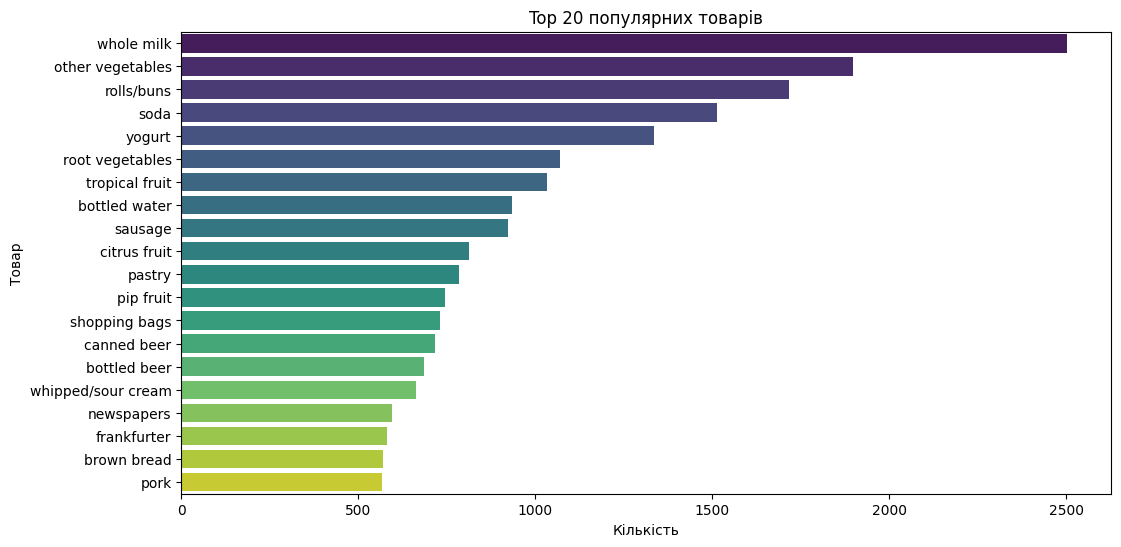

In [6]:
top_items = df['itemDescription'].value_counts().head(20)
plt.figure(figsize=(12,6))
sns.barplot(x=top_items.values, y=top_items.index, palette="viridis")
plt.title("Top 20 популярних товарів")
plt.xlabel("Кількість")
plt.ylabel("Товар")
plt.show()

In [7]:
transactions = df.groupby('Member_number')['itemDescription'].apply(list).tolist()

In [8]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

In [9]:
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)
print("Кількість частотних наборів:", len(frequent_itemsets))

Кількість частотних наборів: 3016


In [10]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules_sorted = rules.sort_values(['lift', 'confidence'], ascending=[False, False])

In [11]:
top10_rules = rules_sorted.head(10)

In [12]:
top10_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
11037,"(whole milk, other vegetables, sausage)","(yogurt, rolls/buns)",0.050282,0.111339,0.013597,0.270408,2.428689,1.0,0.007998,1.218025,0.619400,0.091854,0.178999,0.196264
11048,"(yogurt, rolls/buns)","(whole milk, other vegetables, sausage)",0.111339,0.050282,0.013597,0.122120,2.428689,1.0,0.007998,1.081831,0.661957,0.091854,0.075641,0.196264
11041,"(yogurt, rolls/buns, other vegetables)","(whole milk, sausage)",0.052335,0.106978,0.013597,0.259804,2.428575,1.0,0.007998,1.206467,0.620721,0.093310,0.171133,0.193451
11044,"(whole milk, sausage)","(yogurt, rolls/buns, other vegetables)",0.106978,0.052335,0.013597,0.127098,2.428575,1.0,0.007998,1.085650,0.658702,0.093310,0.078893,0.193451
8858,"(curd, yogurt)","(whole milk, sausage)",0.040277,0.106978,0.010005,0.248408,2.322046,1.0,0.005696,1.188173,0.593239,0.072897,0.158372,0.170966
8863,"(whole milk, sausage)","(curd, yogurt)",0.106978,0.040277,0.010005,0.093525,2.322046,1.0,0.005696,1.058742,0.637549,0.072897,0.055483,0.170966
11033,"(whole milk, rolls/buns, sausage)","(yogurt, other vegetables)",0.048743,0.120318,0.013597,0.278947,2.318415,1.0,0.007732,1.219997,0.597810,0.087459,0.180326,0.195977
11052,"(yogurt, other vegetables)","(whole milk, rolls/buns, sausage)",0.120318,0.048743,0.013597,0.113006,2.318415,1.0,0.007732,1.072451,0.646451,0.087459,0.067556,0.195977
11038,"(yogurt, whole milk, other vegetables)","(rolls/buns, sausage)",0.071832,0.082350,0.013597,0.189286,2.298554,1.0,0.007681,1.131903,0.608665,0.096715,0.116532,0.177197
11047,"(rolls/buns, sausage)","(yogurt, whole milk, other vegetables)",0.082350,0.071832,0.013597,0.165109,2.298554,1.0,0.007681,1.111724,0.615642,0.096715,0.100496,0.177197


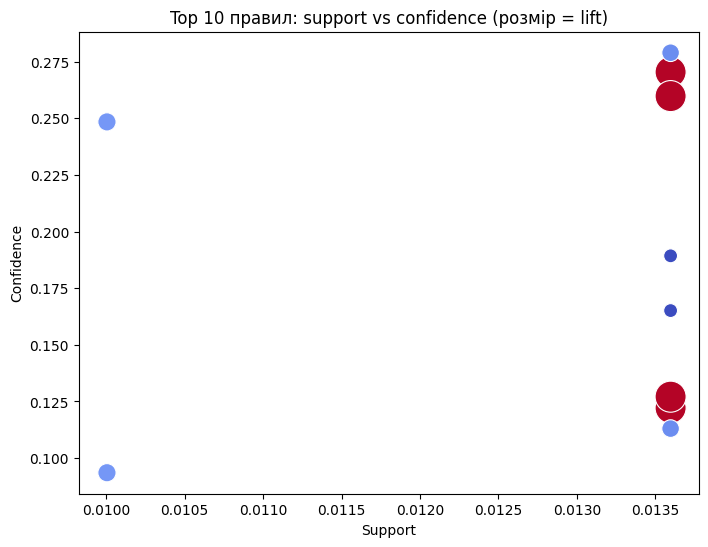

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="support", y="confidence", size="lift", hue="lift", data=top10_rules, palette="coolwarm", legend=False, sizes=(100,500))
plt.title("Top 10 правил: support vs confidence (розмір = lift)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.show()

In [16]:
items_ante = []
items_cons = []
lifts = []

for _, row in top10_rules.iterrows():
    for ant in row['antecedents']:
        for cons in row['consequents']:
            items_ante.append(ant)
            items_cons.append(cons)
            lifts.append(row['lift'])

heatmap_df = pd.DataFrame({
    "Antecedent": items_ante,
    "Consequent": items_cons,
    "Lift": lifts
})

heatmap_pivot = heatmap_df.pivot_table(
    index="Antecedent",
    columns="Consequent",
    values="Lift",
    aggfunc="max",
    fill_value=0
)

fig = px.imshow(
    heatmap_pivot,
    text_auto=True,
    color_continuous_scale="YlGnBu",
    labels=dict(x="Consequent", y="Antecedent", color="Lift"),
    title="Heatmap Lift (Top 10 правил)"
)

fig.update_layout(
    template="plotly_white",
    title_x=0.5
)

fig.show()
